# Germany Inc Shareholders - Data exploration

## Table of contents

[I. Loading the data]  
[II. Consolidation](#section_id)  
&nbsp;&nbsp;&nbsp;&nbsp;[1. Overview](#1.-overview)  
&nbsp;&nbsp;&nbsp;&nbsp;[2. Preprocessing](#2.-preprocessing)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[a. using information from "Key Identity"](#a.-using-information-from-key-identity)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[b. Using the cleaning script from "Key Identity"](#b.-using-the-cleaning-script-from-key-identity)  
&nbsp;&nbsp;&nbsp;&nbsp;[3. Finding promising matches](#3.-finding-promising-matches)  
[III. Next steps](#iii.-next-steps)

## I. Loading the data

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('../data/mydata.csv', low_memory=False)
# Print the first few rows of the data
df.head()

,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
0,1,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,ROTHENBERGER Vermögensverwaltung GbR 4xS,NaN,29.62,NaN,NaN,1999-05-11,29.62,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1,2,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,"Rothenberger, Dr., Helmut",NaN,11.93,NaN,NaN,1995-10-07,11.93,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
2,3,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,"Schneider, Franz Jürgen",NaN,33.10,NaN,NaN,1998-07-08,33.10,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
4,5,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Deutschland Gesellschaft für Industriebetei...,NaN,23.34,NaN,NaN,1998-07-08,23.34,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0


<a id='section_id'></a>

## II. Consolidation

### 1. Overview

In order to implement any of the rules, we need to consolidate the list of shareholders. First, I will group all entries by exact matches and sort them from the largest to smallest group. Then, I will create a plot that shows every 100th row of that sorted dataframe.



14457


,notifying_party,counts
1858,"BlackRock, Inc.",9412
1172,Axxion S.A.,4951
3201,DWS Investment GmbH,4218
822,Allianz Global Investors GmbH,3636
12661,"The Capital Group Companies, Inc.",3251
13072,Universal-Investment-Gesellschaft mit beschrän...,3142
1392,Baden-Württembergische Versorgungsanstalt für ...,2926
7451,LBBW Asset Management Investmentgesellschaft mbH,2740
1846,"BlackRock Holdco 2, Inc.",2735
14169,"Zours, Wilhelm Konrad Thomas",2609


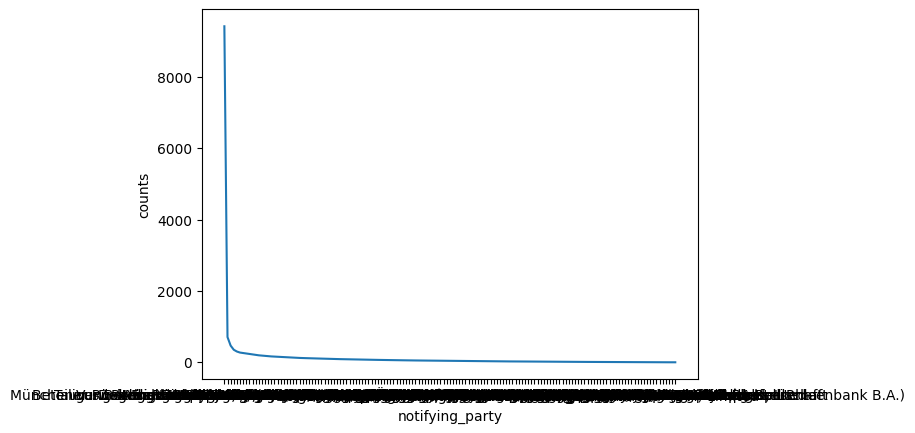

In [168]:
# group by notifying party and aggregate the number of entries
df_grouped = df.groupby(['notifying_party']).size().reset_index(name='counts')
print(len(df_grouped))
# sort this dataframe by the number of entries
df_grouped = df_grouped.sort_values(by=['counts'], ascending=False)
# plot only every 100th entry to generate it faster
sns.lineplot(x='notifying_party', y='counts', data=df_grouped[::100])
df_grouped.head(20)


Among the shareholders with the highest numbers of records, there is a high number of asset managers. The largest groups also account for the bulk of the overall number of records. This can also be spot-checked by inserting a statement like df_grouped['counts'].iloc[some index, like 5846 or 11937 or 14101] below the line where dataframe is sorted.

### 2. Preprocessing
#### a. Using information from "Key Identity"

Since cases that can not be reliably detected automatically will later be checked manually, it is important to remove as many obvious misspellings as possible before that. From the "Key" part of the Germany Inc. project, we already have a list that i.a. contains various all spellings of the companies as they appear in the "issuers" column.

In [169]:
df_dba_spellings = pd.read_csv('../data/names.csv')
print(len(df_dba_spellings))
df_dba_spellings.head()

17821


,Unnamed: 0,wkn,name,isin,ag,id,company_id
0,1,121806,Altira Aktiengesellschaft,DE0001218063,altiraag,1,1
1,2,121806,FinLab AG,DE0001218063,finlabag,1,1
2,3,121806,Themis Capital Group AG,NaN,themiscapitalgroupag,1,1
3,4,126174,UTIMACO Safeware Aktiengesellschaft,DE0001261741,utimacosafewareag,2,2
4,5,126174,Utimaco Safeware AG,DE0001261741,utimacosafewareag,2,2


It is somewhat surprising that this dataframe is larger than the one containing the unique spellings of the shareholders (~17k vs. ~14.5k). One explanation for this might be that these spellings do not only come from BaFin data, but derive from various sources. An even more likely explanation is that the dataframe does not contain only unique values for "name", but it contains all unique records about each company, including scenarios in which the name stays the same but only the ISIN changes, below at the example of Allianz SE:

In [170]:
result = df_dba_spellings[df_dba_spellings['name'] == 'Allianz SE']
result

,Unnamed: 0,wkn,name,isin,ag,id,company_id
4893,4894,590811,Allianz SE,US0188051017,allianzse,1100,785
12682,12683,840400,Allianz SE,DE0008404054,allianzse,1100,785
12683,12684,840400,Allianz SE,DE0008404005,allianzse,1100,785
14845,14846,A0N3R6,Allianz SE,DE000A0N3R67,allianzse,1100,785
15020,15021,A0SLN7,Allianz SE,DE000A0SLN79,allianzse,1100,785
15755,15756,A14KSS,Allianz SE,DE000A14KSS9,allianzse,1100,785
16343,16344,A1MMAX,Allianz SE,DE000A1MMAX8,allianzse,1100,785
16480,16481,A1R1EB,Allianz SE,DE000A1R1EB2,allianzse,1100,785
16719,16720,A1YC87,Allianz SE,DE000A1YC871,allianzse,1100,785
16800,16801,A254VC,Allianz SE,DE000A254VC5,allianzse,1100,785


So we first need to drop duplicates based on the "name" column. Then, we will join the dataframe that contains the spelling alternatives of the issuers `df_dba_spellings` on the `notifying_party` column of the `df_grouped` dataframe. Below, I have filtered the resulting dataframe so that we can see rows in which company_id is not NaN.

In [171]:
df_dba_spellings.drop_duplicates(subset=['name'], inplace=True)
# print(len(df_dba_spellings))

df_grouped = df_grouped.merge(df_dba_spellings, left_on='notifying_party', right_on='name', how='left')
df_grouped_notna = df_grouped[df_grouped['company_id'].notna()]



#### b. Using the cleaning script from "Key Identity"

There is already a regex preprocessing script for the Key Identity data that we can also use for the shareholder data. Originally, it was written in R, so I converted it to Python:

In [172]:
import re

def clean_name(name):
    if type(name) == str:
        name = name.lower()
        name = re.sub('aktiengesellschaft', 'ag', name)
        name = re.sub('kommanditgesellschaft auf aktien', 'kgaa', name)
        name = re.sub('&', 'und', name)
        name = re.sub('ß', 'ss', name)
        name = re.sub('ö', 'oe', name)
        name = re.sub('ü', 'ue', name)
        name = re.sub('ä', 'ae', name)
        name = re.sub('i\.l\.', '', name)
        name = re.sub('i\.k\.', '', name)
        name = re.sub('i\.a\.', '', name)
        name = re.sub('i\.a', '', name)
        name = re.sub('\-', '', name)
        name = re.sub('\:', '', name)
        name = re.sub('_', '', name)
        name = re.sub('\+', '', name)
        name = re.sub(',', '', name)
        name = re.sub('\?', '', name)
        name = re.sub("'", '', name)
        name = re.sub('\.', '', name)
        name = re.sub('/', '', name)
        name = re.sub('!', '', name)
        name = re.sub('<', '', name)
        name = re.sub('>', '', name)
        name = re.sub('"', '', name)
        name = re.sub('„', '', name)
        name = re.sub('“', '', name)
        name = re.sub('”', '', name)
        name = re.sub('·', '', name)
        name = re.sub('\s', '', name)
        name = name.strip()
    return name

We can apply these rules later to the dataframe columns of the dataframe created in the next step with the goal to create more exact matches and remove them.

### 3. Finding promising matches

In order to consolidate the list, it is necessary to find a balanced solution to two challenges: (1) Matching entries that are misspelled, but refer to the same shareholder, and (2) not matching those entries that sound similar, but refer to different companies. I will try to achieve this using fuzzy matching algorithms. 

Fuzzy matching is a technique used to identify records that are likely to be duplicates, but may have slight variations in their spellings, such as typos or variations in formatting. One common method used in fuzzy matching is the Levenshtein distance, which is a measure of the difference between two strings. The Levenshtein distance algorithm calculates the minimum number of single-character edits (insertions, deletions or substitutions) required to change one string into the other. By comparing the Levenshtein distance between two strings, the algorithm can assign a score based on the strings' similarity, with a lower distance indicating a higher likelihood of a match. This method is useful in matching entries that are misspelled but referring to the same shareholder.

To check whether this is a suitable approach, I will evaluate the quality of matches on a subset of the dataset which are above a distance threshold, i.e., they can only be so far away from the target string. I will use the sorted version of the grouped dataframe  for exploration purposes because I would like to view records that are likely to have many variations in the dataset.

In [173]:
from thefuzz import fuzz
from thefuzz import process

def get_matches(origin_df, name_column, company_id_column, target_start, target_end, threshold):
    # create a dataframe to store the best matches
    df_best_matches = pd.DataFrame(columns=['distance', 'target_string', 'matched_string', 'target_index', 'match_index', 'target_company_id', 'match_company_id'])
    
    for target_row in range(target_start, target_end):
        # get the target string, the company id and derive the index of the target string
        target_string = origin_df[name_column].iloc[target_row]
        target_company_id = origin_df[company_id_column].iloc[target_row]
        target_index = origin_df.index[origin_df['notifying_party'] == target_string].values[0]
        
        # clean the target string
        target_string = clean_name(target_string)

        # create a temporary dataframe to store the matches
        df_temp = origin_df[['notifying_party', 'company_id']].copy()
        # fill all rows with the target string because we want to compare it with all other strings
        df_temp.loc[:, 'target_string'] = target_string
        # clean the notifying party column and store it in a new column
        df_temp['matched_string'] = df_temp['notifying_party']
        df_temp['matched_string'] = df_temp['matched_string'].apply(lambda x: clean_name(x))
        # calculate the distance between the target string and the notifying party
        df_temp.loc[:, 'distance'] = df_temp.apply(lambda row: fuzz.ratio(row['matched_string'], target_string), axis=1)

        # store the index of the target string and the notifying party
        df_temp['target_index'] = target_index
        match_index = origin_df.index[origin_df['notifying_party'] == df_temp['notifying_party']].values
        df_temp['match_index'] = match_index

        # store the company id of the target string and the notifying party
        df_temp.loc[:, 'target_company_id'] = target_company_id
        df_temp.loc[:, 'match_company_id'] = df_temp['company_id']
        
        # append the best matches to the dataframe
        df_best_matches = pd.concat([df_best_matches, df_temp[df_temp["distance"] > threshold]])

    # exclude matches with a distance of 100
    df_best_matches = df_best_matches[df_best_matches['distance'] < 100]
    # drop the notifying party and company id columns
    df_best_matches.drop(columns=['notifying_party', 'company_id'], inplace=True)

    # the following block gets rid of all duplicate rows. First, I created a new column that contains the index pair as a tuple
    df_best_matches['index_pair'] = df_best_matches.apply(lambda row: (row['target_index'], row['match_index']), axis=1)
    # create a column that contains the sorted index pair
    df_best_matches['sorted_index_pair'] = df_best_matches['index_pair'].apply(lambda x: tuple(sorted(x)))
    # drop duplicates
    df_best_matches.drop_duplicates(subset='sorted_index_pair', inplace=True)
    # drop the auxiliary columns again
    df_best_matches.drop(columns=['index_pair', 'sorted_index_pair'], inplace=True)

    return df_best_matches

# get matches from the 0th to the 100th row with a threshold distance of 95
test_df = get_matches(df_grouped, 'notifying_party', 'company_id', 0, 100, 95)
test_df

,distance,target_string,matched_string,target_index,match_index,target_company_id,match_company_id
14050,99,threadneedleassetmanagementholdingslimited,threadneedleassetmanagementholdinglimited,55,14050,NaN,NaN
10074,97,dekainvestmentgmbh,dekainvstmentgmbh,89,10074,NaN,NaN
12874,97,porschewolfgang1beteiligungsgmbhundcokg,porschewolfgang2beteiligungsgmbhundcokg,97,12874,NaN,NaN


We can use this dataframe (the first dataframe, still need to structure this section properly!) to manually consolidate the list with the remaining pairs above a certain threshold. For this, we can save the dataframe and use it as a CSV [here](https://github.com/KensingtonOscupant/germanyinc-shareholders-clu).

In [174]:
# export the dataframe to a csv file
# test_df.to_csv('../data/sample_data.csv', index=False)

Now that we have a way to create pairs, we can check which scores the pairs got that we were able to sort out using the "Key Identity" data.

666
239


,distance,target_string,matched_string,target_index,match_index,target_company_id,match_company_id
8070,10,mybetholdingse,jaxxag,6471,8070,682.0,682.0
10213,17,busberzeliusumweltserviceag,nordagag,10020,10213,353.0,353.0
3147,17,tfgcapitalagunternehmensbeteiligungsgesellschaft,vestcorpag,813,3147,1496.0,1496.0
6015,17,sapag,sapagsystemeanwendungenprodukteinderdatenverar...,5296,6015,1350.0,1350.0
6015,17,sapse,sapagsystemeanwendungenprodukteinderdatenverar...,1736,6015,1350.0,1350.0
...,...,...,...,...,...,...,...
5433,48,ambaachenerundmuenchenerbeteiligungsag,ambgeneraliholdingag,2930,5433,1515.0,1515.0
2930,48,ambgeneraliholdingag,ambaachenerundmuenchenerbeteiligungsag,438,2930,1515.0,1515.0
1174,49,unicreditbankag,bayerischehypoundvereinsbankag,203,1174,1746.0,1746.0
203,49,bayerischehypoundvereinsbankag,unicreditbankag,66,203,1746.0,1746.0


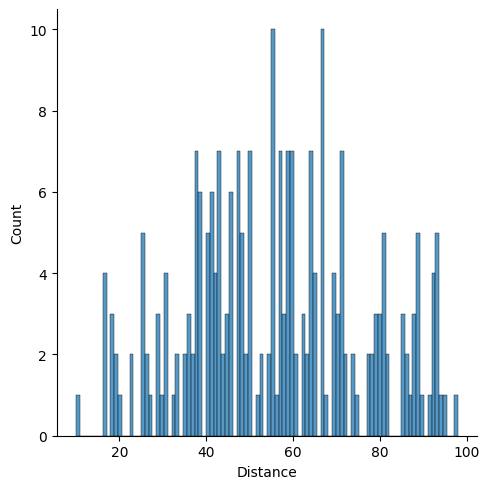

In [175]:
print(len(df_grouped_notna))
dba_score_df = get_matches(df_grouped_notna, 'notifying_party', 'company_id', 0, len(df_grouped_notna), 0)
# only keep the pairs where the company ids are the same
dba_score_df = dba_score_df[dba_score_df['target_company_id'] == dba_score_df['match_company_id']]
# sort dba_score_df by the distance in descending order
dba_score_df = dba_score_df.sort_values(by=['distance'], ascending=True)

print(len(dba_score_df))
display(dba_score_df.head(100))

# plot the distribution of the distances
plot = sns.displot(dba_score_df['distance'], kde=False, bins=100)
plot.set(xlabel='Distance', ylabel='Count')



This shows that there are often fundamental differences that go way beyond simple spelling mistakes, which will make it harder to match all of them correctly. However, spelling will also play an important role for the companies already included as issuers because there are additional spellings of these companies in the shareholder data that have not yet been captured in the "Key Identity" names file (e.g. company id 617).

## III. Next steps

Although hardcoded rules (changing Limited to Ltd etc) will be helpful with preprocessing, they will not be able to solve the challenge on their own with the perfect accuracy that we need. This is what I would suggest instead:

a. determine an appropriate threshold with which we can be sure to get all matches but not include too many

b. get a list of all potential matches above that threshold and remove the duplicates, save as CSV

c. write a command line utility that allows users to do the work themselves, more details here

    aa. load a copy of the above dataframe except for the distance and add an extra column for an id, the preliminary "company_id" (which is not correct yet at first)

    bb. display the two companies and offer three keys to press: "n" for "not the same company", and if it is the same company "1" for using the left one as the correct name and "2" for the right one. For "n", it assigns 0, and in case of "1" and "2" it assigns the same id for two, always choosing one above the last one given.

d. for all names that appear in more than two lines, group them.

e. create a copy of the grouped dataframe and resolve all the conflicts, keeping only the rows with the correct name.

f. back in the grouped dataframe from d., assign the name to all spelling variants in the group that the correct spelling you decided on came from.

g. Also in the grouped dataframe, ssign ids to the remaining records that have not had any matches

h. In the original dataframe df, add a column company_id and add the correct labels from the grouped dataframe based on notifying_party and the string in the grouped dataframe (maybe join on notifying_party?)

NOTE: If matches at a distance of 95 still return names that are misspelled, then the threshold should be more generous, i.e. include more matches. In the manual check, we need to classify a few matches as incorrect to determine that we actually catch all the ones that are there. 
Also, I am still concerned about situations like "Universal-Investment-Gesellschaft mbH" and "Universal-Investment-Gesellschaft mit beschränkter Haftung", where the latter is is still among the best matches, but only has a score of 67 or so because the difference is so seemingly big. Bearing this in mind, it might actually help to base the decision on what to show the user not (only) on a threshold, but also on a minimum number of entries in case there are no good ones and the actual matches just start at lower ones.